In [62]:
%pylab inline
import pandas as pd
human_orthology = pd.read_table('/home/cmb-panasas2/skchoudh/genomes/ensemble_orthology/human-mouse/human_query.tsv').set_index('ensembl_gene_id')
mouse_orthology = pd.read_table('/home/cmb-panasas2/skchoudh/genomes/ensemble_orthology/human-mouse/mouse_query.tsv').set_index('ensembl_gene_id')

Populating the interactive namespace from numpy and matplotlib


In [56]:
orthology

,hsapiens_homolog_ensembl_gene,hsapiens_homolog_perc_id_r1,hsapiens_homolog_orthology_type,hsapiens_homolog_subtype,hsapiens_homolog_perc_id
ensembl_gene_id,,,,,
ENSMUSG00000064370,ENSG00000198727,78.1579,ortholog_one2one,Eutheria,77.9528
ENSMUSG00000064368,ENSG00000198695,52.2989,ortholog_one2one,Boreoeutheria,52.9070
ENSMUSG00000064367,ENSG00000198786,63.8474,ortholog_one2many,Eutheria,63.4267
ENSMUSG00000064363,ENSG00000198886,66.8845,ortholog_one2one,Eutheria,66.8845
ENSMUSG00000065947,ENSG00000212907,66.3265,ortholog_one2one,Eutheria,66.3265
ENSMUSG00000064360,ENSG00000198840,66.0870,ortholog_one2one,Eutheria,66.0870
ENSMUSG00000064358,ENSG00000198938,86.9732,ortholog_one2one,Euarchontoglires,86.9732
ENSMUSG00000064357,ENSG00000198899,75.6637,ortholog_one2one,Eutheria,75.6637
ENSMUSG00000064356,ENSG00000228253,45.5882,ortholog_one2one,Euarchontoglires,46.2687


In [64]:
mouse_orthology.loc[['ENSG00000264452', 'ENSG00000264452']]

,mmusculus_homolog_ensembl_gene,mmusculus_homolog_perc_id_r1,mmusculus_homolog_orthology_type,mmusculus_homolog_perc_id
ensembl_gene_id,,,,
ENSG00000264452,ENSMUSG00000093784,71.0526,ortholog_one2one,71.0526
ENSG00000264452,ENSMUSG00000093784,71.0526,ortholog_one2one,71.0526


In [2]:

# coding: utf-8

# In[33]:


import importlib
import os
import json
import pickle
import re
import sys
import numpy as np
import pandas as pd
import tensorflow as tf


from keras.models import load_model
from keras.utils import to_categorical
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Embedding, Bidirectional
#Dropout, RepeatVector, TimeDistributed, AveragePooling1D, Flatten
from collections import defaultdict, OrderedDict
from scipy.stats import describe
print(K.backend())
def set_keras_backend(backend):
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        importlib.reload(K)
        assert K.backend() == backend


#set_keras_backend('theano')
__BASES__ = ['A','C','G','T']
__BASES_MAP__ = OrderedDict(zip(__BASES__,range(4)))
__MERGE_KEYS__ = ['UTR5', 'CDS', 'UTR3']
__MERGE_LABELS__ = OrderedDict(zip(__MERGE_KEYS__, range(3)))


# In[21]:
def _downsample(genes_histogram, genes_to_keep=10000):
    """Downsample a histogram by randomly dropping proportional
    number of genes in each bin

    Params
    ------

    genes_histogram : dict
        Dictionary with format {bin:[list of genes in bin]}

    genes_to_keep : int
        Total genes to keep

    Return
    ------
    downsampled_dict : dict
        Dictionary with downsampled list in each bin

    """
    np.random.seed(42)
    downsampled_dict = {}
    total_bins = len(genes_histogram)
    total_genes = sum([len(x) for x in list(genes_histogram.values())])
    scaling_factor = genes_to_keep / total_genes
    for bin_index, genes_in_bin in list(genes_histogram.items()):
        n_genes_in_bin = len(genes_in_bin)
        n_genes_to_keep = int(np.ceil(n_genes_in_bin * scaling_factor))
        index_genes_to_keep = np.random.choice(n_genes_in_bin, n_genes_to_keep)
        genes_to_keep = np.array(genes_in_bin)[index_genes_to_keep]
        downsampled_dict[bin_index] = list(genes_to_keep)
    return downsampled_dict


def load_data(gene_cds, gene_lengths, genes_to_keep=10000):
    """Load dataset

    Params
    ------
    gene_cds : str
        Path to json with sequence

    gene_lengths : str
        Path to json with sequence lengths

    genes_to_keep : int
        Total genes_to_keep

    Return
    ------
    downsampled_genes_dict : dict
        Dictionary with format {bin:[list of genes in bin]}

    """
    np.random.seed(42)

    gene_seq = OrderedDict(json.load(open(gene_cds)))
    gene_len = OrderedDict(json.load(open(gene_lengths)))

    gene_total_len = OrderedDict((k, sum(list(v.values())))
                                 for k, v in list(gene_len.items()))
    all_lengths = np.array(list(gene_total_len.values()))
    valid_genes_dict = OrderedDict((k, v)
                                   for k, v in list(gene_total_len.items())
                                   if v < 10000)

    valid_genes_keys = list(valid_genes_dict.keys())
    valid_genes_values = list(valid_genes_dict.values())
    hist, edges = np.histogram(valid_genes_values)
    valid_genes_bins = np.digitize(valid_genes_values, edges)
    length_wise_binned_genes = defaultdict(list)
    for i, b in enumerate(valid_genes_bins):
        length_wise_binned_genes[b - 1].append(valid_genes_keys[i])

    downsampled_genes_dict = _downsample(length_wise_binned_genes,
                                         genes_to_keep=genes_to_keep)
    return downsampled_genes_dict, gene_seq


def split_train_test_genes(length_wise_binned_genes, train_proportion=0.7):
    """Split data in training and testing set

    Params
    ------
    length_wise_binned_genes : dict
         Dictionary with format {bin:[list of genes in bin]}

    train_proportion : float
        Training proportion

    Return
    ------
    training_genes : list

    testing_genes : list

    """
    np.random.seed(42)
    training_genes = []
    testing_genes = []
    for bin_number, bin_genes in list(length_wise_binned_genes.items()):
        n_genes = len(bin_genes)
        np.random.shuffle(bin_genes)
        training_genes += bin_genes[:int(n_genes * train_proportion)]
        testing_genes += bin_genes[int(n_genes * train_proportion):]

    return training_genes, testing_genes

# In[9]:


def map_base_to_int(base):
    """Return int given a base character"""
    return __BASES_MAP__[base]


def one_hot_encoding(data_dict):
    """One hot encode sequences

    Params
    ------
    data_dict : dict
        Sequence dict as loaded from gene_cds json file

    Returns
    -------

    X : array
        X*4 Input array with columns representing A,T,G,C

    Y : array
        X*3 Labels with columns representing 5'UTR, CDS, 3'UTR


    """
    merged_seq = []
    merged_label = []
    for key in __MERGE_KEYS__:
        merged_seq += list(data_dict[key])
        merged_label += list([__MERGE_LABELS__[key]] * len(data_dict[key]))
    merged_seq_int = list(map(map_base_to_int, merged_seq))

    X = merged_seq_int #to_categorical(merged_seq_int)
    Y = to_categorical(merged_label)
    return X, Y


# In[49]:

def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=4, output_dim=4))
    model.add(Bidirectional(LSTM(
                3,
                return_sequences=True,
                input_shape=(None, 4),
                dropout=0.5,
                recurrent_dropout=0.25)))
    model.add(Dense(3, activation='sigmoid'))
    model.compile(
        loss='categorical_crossentropy',
        optimizer='rmsprop',
        metrics=['accuracy'])
    return model

def load_trained_model(weights_path=None):
    model = create_model()
    if weights_path:
        model.load_weights(weights_path)
    return model

def train(X_train, Y_train, X_test, Y_test, weights_path=None, start_epoch=0):
    model = load_trained_model(weights_path)
    nb_epoch = 128
    train_history = defaultdict(list)
    test_history = defaultdict(list)

    for e in range(start_epoch, nb_epoch):
        index = 0
        acc_train = 0
        for x, y in zip(X_train, Y_train):
            acc = model.train_on_batch(np.array([x]), np.array([y]))#, verbose=0)
            train_history[e].append(acc)
            acc_train+=acc[1]
            if (index%10000) == 0:
                sys.stderr.write('Epoch: {} || Index :{} || loss: {} || acc: {}\n'.format(e, index, acc[0], acc[1]))
                with open('train_acc_10000.log', 'a') as f:
                    f.write('Epoch: {} || Index :{} || loss: {} || acc: {}\n'.format(e, index, acc[0], acc[1]))
                ##for x_test, y_test in zip(X_test, Y_test):
                ##    prediction = model.evaluate(np.array([x_test]),np.array([y_test]), batch_size=1)
                ##    print (prediction)
            index += 1
        acc_train /= len(X_train)
        sys.stderr.write('Epoch: {} || Train acc: {}\n'.format(e, acc_train))
        with open('train_acc_10000.log', 'a') as f:
            f.write('Epoch: {} || Train acc: {}\n'.format(e, acc_train))
        acc_test = 0
        for x_test, y_test in zip(X_test, Y_test):
            #acc_test = model.predict_classes(np.array([x_test]), batch_size=1)
            acc = model.evaluate(np.array([x_test]),np.array([y_test]), batch_size=1)
            acc_test += acc[1]
        acc_test /= len(X_test)
        test_history[e].append(acc_test)
        sys.stdout.write('Epoch: {} || Test acc: {}\n'.format(e, acc_test))
        with open('test_acc_10000.log', 'a') as f:
            f.write('Epoch: {} || Test acc: {}\n'.format(e, acc_test))

        model.save('lstm-dropout_025_recur_dropout_025-epoch-{}_10000.h5'.format(e))

    return model, train_history


# In[11]:




weights_file = '../notebooks_embedding_bilstm/lstm-dropout_025_recur_dropout_025-epoch-9_10000.h5'
last_epoch = int(re.search('epoch-\d+', weights_file).group(0).split('-')[1])

gene_cds = '../data/hg38/input/genes_cds.json'
gene_lengths = '../data/hg38/input/genes_lengths.json'

genes_dict, gene_seq = load_data(gene_cds, gene_lengths, genes_to_keep=10000)

training_genes, test_genes = split_train_test_genes(genes_dict, train_proportion=0.7)

## Shuffle the genes once again to avoid any bin wise correlation

np.random.shuffle(training_genes)
np.random.shuffle(test_genes)

X_train = []
Y_train = []

X_test = []
Y_test = []

for gene in training_genes:
    X, Y = one_hot_encoding(gene_seq[gene])
    X_train.append(X)
    Y_train.append(Y)

for gene in test_genes:
    X, Y = one_hot_encoding(gene_seq[gene])
    X_test.append(X)
    Y_test.append(Y)


#model, trainhist = train(X_train, Y_train, X_test, Y_test, weights_file, last_epoch)




Using TensorFlow backend.


tensorflow


NameError: name 'weights_path' is not defined

In [3]:
model = load_trained_model(weights_file)

In [29]:
gene_lengths_dict = json.load(open(gene_lengths))
mouse_gene_lengths_dict = json.load(open(mouse_gene_lengths))

In [38]:
mouse_gene_cds = '../data/mm10/input/genes_cds.json'
mouse_gene_lengths = '../data/mm10/input/genes_lengths.json'



mouse_genes_dict, mouse_gene_seq = load_data(mouse_gene_cds, mouse_gene_lengths, 
                                             genes_to_keep=20108)

mouse_training_genes, mouse_test_genes = split_train_test_genes(mouse_genes_dict, train_proportion=0.7)

mouse_X_train = []
mouse_Y_train = []

mouse_X_test = []
mouse_Y_test = []

mouse_training_genes_filtered = []
mouse_test_genes_filtered  = []

for gene in mouse_training_genes:
    if 'N' in ('').join(mouse_gene_seq[gene].values()):
        continue
    X, Y = one_hot_encoding(mouse_gene_seq[gene])
    mouse_X_train.append(X)
    mouse_Y_train.append(Y)
    mouse_training_genes_filtered.append(gene)


for gene in mouse_test_genes:
    if 'N' in ('').join(mouse_gene_seq[gene].values()):
        continue
    X, Y = one_hot_encoding(mouse_gene_seq[gene])
    mouse_X_test.append(X)
    mouse_Y_test.append(Y)
    mouse_test_genes_filtered.append(gene)

In [44]:
acc_test = []
for  x_test, y_test in zip(X_test, Y_test):
    #acc_test = model.predict_classes(np.array([x_test]), batch_size=1)
    #break
    acc = model.evaluate(np.array([x_test]),np.array([y_test]), batch_size=1, verbose=0)
    acc_test.append(acc[1])
acc_test = np.array(acc_test)

In [45]:
acc_train = []
for  x_train, y_train in zip(X_train, Y_train):
    #acc_train = model.predict_classes(np.array([x_train]), batch_size=1)
    #break
    acc = model.evaluate(np.array([x_train]),np.array([y_train]), batch_size=1, verbose=0)
    acc_train.append(acc[1])
acc_train = np.array(acc_train)

In [39]:
mouse_acc_test = []
for  x_test, y_test in zip(mouse_X_test, mouse_Y_test):
    #acc_test = model.predict_classes(np.array([x_test]), batch_size=1)
    #break
    mouse_acc = model.evaluate(np.array([x_test]),np.array([y_test]), batch_size=1, verbose=0)
    mouse_acc_test.append(mouse_acc[1])
mouse_acc_test = np.array(mouse_acc_test)

In [40]:
mouse_acc_train = []
for  x_train, y_train in zip(mouse_X_train, mouse_Y_train):
    #acc_train = model.predict_classes(np.array([x_train]), batch_size=1)
    #break
    mouse_acc = model.evaluate(np.array([x_train]),np.array([y_train]), batch_size=1, verbose=0)
    mouse_acc_train.append(mouse_acc[1])
mouse_acc_train = np.array(mouse_acc_train)

In [43]:
import pickle

pickle.dump(mouse_test_genes_filtered, open('notebooks_embedding_bilstm_epoch-9/mouse_test_genes_filtered.pickle', 'wb'))
pickle.dump(mouse_training_genes_filtered, open('notebooks_embedding_bilstm_epoch-9/mouse_train_genes_filtered.pickle', 'wb'))
pickle.dump(mouse_acc_test, open('notebooks_embedding_bilstm_epoch-9/mouse_acc_test.pickle', 'wb'))
pickle.dump(mouse_acc_train, open('notebooks_embedding_bilstm_epoch-9/mouse_acc_train.pickle', 'wb'))




In [46]:
pickle.dump(test_genes, open('notebooks_embedding_bilstm_epoch-9/human_test_genes_filtered.pickle', 'wb'))
pickle.dump(training_genes, open('notebooks_embedding_bilstm_epoch-9/human_train_genes_filtered.pickle', 'wb'))
pickle.dump(acc_test, open('notebooks_embedding_bilstm_epoch-9/human_acc_test.pickle', 'wb'))
pickle.dump(acc_train, open('notebooks_embedding_bilstm_epoch-9/human_acc_train.pickle', 'wb'))

In [19]:
acc = model.evaluate(np.array([x_test]),np.array([y_test]), batch_size=1)

1/1 [==============================] - 0s


In [48]:
np.argmax(mouse_acc_test)

4784

In [59]:
np.mean(mouse_acc_train)

0.711858930068478

In [27]:
acc_test[946]

0.99455827474594116

In [49]:
mouse_acc_test[4784]

0.99412786960601807

In [50]:
mouse_test_genes_filtered[4784]

'ENSMUSG00000074030'

In [60]:
orthology.loc['ENSMUSG00000074030']

hsapiens_homolog_ensembl_gene       ENSG00000116903
hsapiens_homolog_perc_id_r1                 92.4138
hsapiens_homolog_orthology_type    ortholog_one2one
hsapiens_homolog_subtype                     Theria
hsapiens_homolog_perc_id                    93.5754
Name: ENSMUSG00000074030, dtype: object

In [61]:
#test_genes[946]
'ENSG00000116903' in training_genes

True

In [30]:
gene_lengths_dict['ENSG00000107164']

{'CDS': 1716, 'UTR3': 1333, 'UTR5': 75}

In [167]:
gene_seq['ENSG00000107164']

{'CDS': 'ATGGCGGAGCTGGTGCAGGGGCAGAGCGCTCCTGTGGGGATGAAGGCCGAGGGCTTCGTGGATGCCCTGCACCGGGTCCGGCAGATTGCTGCTAAAATTGATTCAATTCCTCACTTGAATAATTCCACACCTCTAGTGGACCCCTCAGTATATGGATACGGAGTACAAAAACGGCCCTTGGATGATGGAGTAGGTAACCAGTTAGGGGCCTTGGTACATCAAAGGACGGTAATAACGGAAGAATTCAAAGTGCCTGACAAAATGGTTGGATTTATTATCGGCAGGGGAGGTGAGCAGATTTCACGGATTCAAGCAGAATCTGGTTGCAAAATTCAGATTGCTTCAGAGAGTTCTGGGATTCCAGAGAGGCCCTGTGTACTTACCGGAACCCCAGAAAGTATTGAACAAGCCAAACGGCTCCTGGGACAGATTGTGGACCGCTGTCGAAATGGACCTGGCTTTCATAATGACATAGACAGCAACAGCACAATCCAGGAGATTCTCATTCCCGCATCTAAAGTGGGTCTGGTCATCGGCAGAGGAGGGGAAACAATCAAGCAGTTGCAGGAGCGGACAGGGGTGAAGATGGTCATGATCCAGGATGGCCCATTGCCCACGGGAGCAGACAAGCCTCTTCGTATCACTGGAGATGCATTTAAAGTACAGCAAGCAAGAGAAATGGTACTAGAGATTATCCGAGAAAAAGACCAAGCTGACTTTCGGGGTGTACGCGGCGATTTCAACTCTCGAATGGGAGGAGGCAGTATAGAGGTATCTGTGCCTAGGTTTGCTGTGGGGATTGTAATAGGAAGAAACGGGGAAATGATCAAAAAGATCCAGAATGATGCTGGTGTGAGGATTCAGTTTAAACCAGATGATGGGATTAGTCCAGAAAGAGCTGCCCAGGTCATGGGCCCTCCGGATCGGTGTCAGCATGCAGCGCATATCATCAGCGAGCTGATTCTTACAGCCCAGGAAAGAGACGGCTTTG

In [173]:
acc_test = model.predict_classes(np.array([X_test[946]]), batch_size=1)

1/1 [==============================] - 0s


In [186]:
s = ''
for x in acc_test[0][75+1716:]:
    if x ==0:
        s+='P'
    elif x==1:
        s+='Q'
    elif x==2:
        s+='R'
    

In [187]:
s

'RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR

In [172]:
len('22222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222')

1334

In [33]:
s

'000000000000000000000000000000000000000000000000000000000000000000000111111100111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

In [69]:
orthologous_genes = list(set(mouse_orthology.loc[training_genes].mmusculus_homolog_ensembl_gene.tolist()))

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/py35_rnn/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


In [70]:
orthologous_genes

[nan,
 'ENSMUSG00000091002',
 'ENSMUSG00000001120',
 'ENSMUSG00000025776',
 'ENSMUSG00000003190',
 'ENSMUSG00000029711',
 'ENSMUSG00000045064',
 'ENSMUSG00000015846',
 'ENSMUSG00000022043',
 'ENSMUSG00000041836',
 'ENSMUSG00000030166',
 'ENSMUSG00000030032',
 'ENSMUSG00000040321',
 'ENSMUSG00000003235',
 'ENSMUSG00000048174',
 'ENSMUSG00000021439',
 'ENSMUSG00000037686',
 'ENSMUSG00000100916',
 'ENSMUSG00000059412',
 'ENSMUSG00000013622',
 'ENSMUSG00000024304',
 'ENSMUSG00000072995',
 'ENSMUSG00000025939',
 'ENSMUSG00000032030',
 'ENSMUSG00000058239',
 'ENSMUSG00000039463',
 'ENSMUSG00000046811',
 'ENSMUSG00000038298',
 'ENSMUSG00000055401',
 'ENSMUSG00000001555',
 'ENSMUSG00000078512',
 'ENSMUSG00000040978',
 'ENSMUSG00000028673',
 'ENSMUSG00000079350',
 'ENSMUSG00000035606',
 'ENSMUSG00000038700',
 'ENSMUSG00000003948',
 'ENSMUSG00000064210',
 'ENSMUSG00000026650',
 'ENSMUSG00000001630',
 'ENSMUSG00000028294',
 'ENSMUSG00000036880',
 'ENSMUSG00000066637',
 'ENSMUSG00000026357',
 'ENS

In [132]:
mouse_non_orthologous_genes_accuracy_train = []
for index, acc in enumerate(mouse_acc_train):
    gene = mouse_training_genes_filtered[index]
    if gene not in orthologous_genes:
        mouse_non_orthologous_genes_accuracy_train.append(acc)
    

In [133]:
mouse_non_orthologous_genes_accuracy_test = []
for index, acc in enumerate(mouse_acc_test):
    gene = mouse_test_genes_filtered[index]
    if gene not in orthologous_genes:
        mouse_non_orthologous_genes_accuracy_test.append(acc)
    

In [76]:
accuracy_above_9_train = np.where(mouse_acc_train>0.9)

In [81]:
len(accuracy_above_9_train[0])

2035

In [78]:
accuracy_above_9_test = np.where(mouse_acc_test>0.9)

In [82]:
len(accuracy_above_9_test[0])

886

In [85]:
non_orthologous_train_with_gt_9 = []
for index in accuracy_above_9_train[0]:
    gene = mouse_training_genes_filtered[index]
    if gene not in orthologous_genes:
        non_orthologous_train_with_gt_9.append((gene, index))
        

In [87]:
non_orthologous_test_with_gt_9 = []
for index in accuracy_above_9_test[0]:
    gene = mouse_test_genes_filtered[index]
    if gene not in orthologous_genes:
        non_orthologous_test_with_gt_9.append((gene, index))
        

In [88]:
non_orthologous_test_with_gt_9

[('ENSMUSG00000028461', 4),
 ('ENSMUSG00000094200', 26),
 ('ENSMUSG00000051095', 36),
 ('ENSMUSG00000100856', 41),
 ('ENSMUSG00000093993', 42),
 ('ENSMUSG00000052012', 46),
 ('ENSMUSG00000052012', 52),
 ('ENSMUSG00000079702', 60),
 ('ENSMUSG00000041165', 62),
 ('ENSMUSG00000068082', 75),
 ('ENSMUSG00000079299', 85),
 ('ENSMUSG00000099894', 93),
 ('ENSMUSG00000093895', 94),
 ('ENSMUSG00000100972', 97),
 ('ENSMUSG00000031896', 117),
 ('ENSMUSG00000044120', 123),
 ('ENSMUSG00000101766', 130),
 ('ENSMUSG00000108367', 144),
 ('ENSMUSG00000094181', 153),
 ('ENSMUSG00000090515', 160),
 ('ENSMUSG00000094647', 175),
 ('ENSMUSG00000061991', 179),
 ('ENSMUSG00000095135', 189),
 ('ENSMUSG00000068082', 204),
 ('ENSMUSG00000101146', 213),
 ('ENSMUSG00000110104', 214),
 ('ENSMUSG00000091101', 217),
 ('ENSMUSG00000078131', 231),
 ('ENSMUSG00000043314', 232),
 ('ENSMUSG00000015672', 269),
 ('ENSMUSG00000103371', 277),
 ('ENSMUSG00000079626', 297),
 ('ENSMUSG00000029136', 303),
 ('ENSMUSG00000018286', 3

In [91]:
mouse_gene_seq['ENSMUSG00000094311']

{'CDS': 'TTTGTTTCCTTACTCGAGGTTTTTTCGTCTCTATTACTACGAGTATCCATTTCAGCAACGAAAAGGGTAGTGTTTGAACCAAAGAAGGTATCAGTTCCGATCCTTTTAGGGATGCACCATTTCCGGTCCCGAAGATACCACAGAAAGACTTTATTTTAATTGAGACTAAAGAGAGCAGAAGAGTGGTTCGTTGACCTTGAATACAAGTGCCTCATTTATCTACAAGGAGGACGACTGACCAAGGAACGTTTATGGACCTCGGGTAAGCAAGGAAAAGAGGTGTAGTTGAAGGGTCACCGTCTGACTTTTTTTCACCCTCAACAGGTGCTGTACCCGACTTCTTTACTTAGAAGACCCTAGAAGGTGGTTTAATACTGGTCCGAAGGGTGGGAAATTTAGTAATCTCCCAAGGGCCCTCCTCAGTGGTCAGAATCGACGGTCTCGGCATAAGAGACTATGGTTAGAGTCTTCAGGTCACTAGACGGGAAATACAACGAAGTCATTCCCCGGTACGACGAAATTTTCCTACCGGTCAAGAAAGTAATGGGGTAGTATGAACTGTCCAGAGAAAACAAGAAAAGCTGTGTGCCCTGTCCAGTAATAGTTCAGAAGAAAGAAACAGTAGGTAAAAAATGGCGTTAGTTTCGTTTCATACACCCGCGTCCTCTCTATTTATCCTACTCTCATTTACAGGTCCGTTTAACGTGTCCAACGGAGGTAAAGGTTTTACAAAAGGTAATTCAATAGAACACTTTGAAAATGTATCACTACAAATCTCAGGTTCAAGAGAAAGGAGTA',
 'UTR3': 'TAAGAGCAAGATTGGAGGACCAAGGTAAAGCATTGCACTAAGACTTGGAAGACTTCTGATGAACTCTATAGACTCCTGAGATCACTCTGGGGATAATTATGTTGTAGGCAAATAGCTGTGTACTGTATATTTTTTTTACAGTAAAATATTGTCAATGTTTTATGGATA',
 'UTR5': 

In [115]:
ENSMUSG00000094311 = mouse_gene_seq['ENSMUSG00000094311'].copy()
ENSMUSG00000094311_utr5, ENSMUSG00000094311_utr3 = ENSMUSG00000094311['UTR5'], ENSMUSG00000094311['UTR3']
ENSMUSG00000094311['UTR5'] = ENSMUSG00000094311_utr3
ENSMUSG00000094311['UTR3'] = ENSMUSG00000094311_utr5


In [116]:
ENSMUSG00000094311

{'CDS': 'TTTGTTTCCTTACTCGAGGTTTTTTCGTCTCTATTACTACGAGTATCCATTTCAGCAACGAAAAGGGTAGTGTTTGAACCAAAGAAGGTATCAGTTCCGATCCTTTTAGGGATGCACCATTTCCGGTCCCGAAGATACCACAGAAAGACTTTATTTTAATTGAGACTAAAGAGAGCAGAAGAGTGGTTCGTTGACCTTGAATACAAGTGCCTCATTTATCTACAAGGAGGACGACTGACCAAGGAACGTTTATGGACCTCGGGTAAGCAAGGAAAAGAGGTGTAGTTGAAGGGTCACCGTCTGACTTTTTTTCACCCTCAACAGGTGCTGTACCCGACTTCTTTACTTAGAAGACCCTAGAAGGTGGTTTAATACTGGTCCGAAGGGTGGGAAATTTAGTAATCTCCCAAGGGCCCTCCTCAGTGGTCAGAATCGACGGTCTCGGCATAAGAGACTATGGTTAGAGTCTTCAGGTCACTAGACGGGAAATACAACGAAGTCATTCCCCGGTACGACGAAATTTTCCTACCGGTCAAGAAAGTAATGGGGTAGTATGAACTGTCCAGAGAAAACAAGAAAAGCTGTGTGCCCTGTCCAGTAATAGTTCAGAAGAAAGAAACAGTAGGTAAAAAATGGCGTTAGTTTCGTTTCATACACCCGCGTCCTCTCTATTTATCCTACTCTCATTTACAGGTCCGTTTAACGTGTCCAACGGAGGTAAAGGTTTTACAAAAGGTAATTCAATAGAACACTTTGAAAATGTATCACTACAAATCTCAGGTTCAAGAGAAAGGAGTA',
 'UTR3': 'GATCTCAACCACCAGAGGTCGTTTCCTGAATCCTAGACTGGTGAACACGAAGACATAAATGAACGAGTTCGAGAACCAACTTCATTAG',
 'UTR5': 'TAAGAGCAAGATTGGAGGACCAAGGTAAAGCATTGCACTAAGACTTGGAAGACTTCTGATGAACTCTATAGACTCCTGA

In [117]:
## predict
X_orig, Y_orig = one_hot_encoding(mouse_gene_seq['ENSMUSG00000094311'])
X_fake, Y_fake = one_hot_encoding(ENSMUSG00000094311)

ENSMUSG00000094311_acc_test_fake = model.predict_classes(np.array([X_fake]), batch_size=1)
ENSMUSG00000094311_acc_fake = model.evaluate(np.array([X_fake]),np.array([Y_orig]), batch_size=1)

ENSMUSG00000094311_acc_test_orig = model.predict_classes(np.array([X_orig]), batch_size=1)
ENSMUSG00000094311_acc_orig = model.evaluate(np.array([X_orig]),np.array([Y_orig]), batch_size=1)


1/1 [==============================] - 0s


In [118]:
mouse_gene_seq['ENSMUSG00000094311']

{'CDS': 'TTTGTTTCCTTACTCGAGGTTTTTTCGTCTCTATTACTACGAGTATCCATTTCAGCAACGAAAAGGGTAGTGTTTGAACCAAAGAAGGTATCAGTTCCGATCCTTTTAGGGATGCACCATTTCCGGTCCCGAAGATACCACAGAAAGACTTTATTTTAATTGAGACTAAAGAGAGCAGAAGAGTGGTTCGTTGACCTTGAATACAAGTGCCTCATTTATCTACAAGGAGGACGACTGACCAAGGAACGTTTATGGACCTCGGGTAAGCAAGGAAAAGAGGTGTAGTTGAAGGGTCACCGTCTGACTTTTTTTCACCCTCAACAGGTGCTGTACCCGACTTCTTTACTTAGAAGACCCTAGAAGGTGGTTTAATACTGGTCCGAAGGGTGGGAAATTTAGTAATCTCCCAAGGGCCCTCCTCAGTGGTCAGAATCGACGGTCTCGGCATAAGAGACTATGGTTAGAGTCTTCAGGTCACTAGACGGGAAATACAACGAAGTCATTCCCCGGTACGACGAAATTTTCCTACCGGTCAAGAAAGTAATGGGGTAGTATGAACTGTCCAGAGAAAACAAGAAAAGCTGTGTGCCCTGTCCAGTAATAGTTCAGAAGAAAGAAACAGTAGGTAAAAAATGGCGTTAGTTTCGTTTCATACACCCGCGTCCTCTCTATTTATCCTACTCTCATTTACAGGTCCGTTTAACGTGTCCAACGGAGGTAAAGGTTTTACAAAAGGTAATTCAATAGAACACTTTGAAAATGTATCACTACAAATCTCAGGTTCAAGAGAAAGGAGTA',
 'UTR3': 'TAAGAGCAAGATTGGAGGACCAAGGTAAAGCATTGCACTAAGACTTGGAAGACTTCTGATGAACTCTATAGACTCCTGAGATCACTCTGGGGATAATTATGTTGTAGGCAAATAGCTGTGTACTGTATATTTTTTTTACAGTAAAATATTGTCAATGTTTTATGGATA',
 'UTR5': 

In [119]:
ENSMUSG00000094311

{'CDS': 'TTTGTTTCCTTACTCGAGGTTTTTTCGTCTCTATTACTACGAGTATCCATTTCAGCAACGAAAAGGGTAGTGTTTGAACCAAAGAAGGTATCAGTTCCGATCCTTTTAGGGATGCACCATTTCCGGTCCCGAAGATACCACAGAAAGACTTTATTTTAATTGAGACTAAAGAGAGCAGAAGAGTGGTTCGTTGACCTTGAATACAAGTGCCTCATTTATCTACAAGGAGGACGACTGACCAAGGAACGTTTATGGACCTCGGGTAAGCAAGGAAAAGAGGTGTAGTTGAAGGGTCACCGTCTGACTTTTTTTCACCCTCAACAGGTGCTGTACCCGACTTCTTTACTTAGAAGACCCTAGAAGGTGGTTTAATACTGGTCCGAAGGGTGGGAAATTTAGTAATCTCCCAAGGGCCCTCCTCAGTGGTCAGAATCGACGGTCTCGGCATAAGAGACTATGGTTAGAGTCTTCAGGTCACTAGACGGGAAATACAACGAAGTCATTCCCCGGTACGACGAAATTTTCCTACCGGTCAAGAAAGTAATGGGGTAGTATGAACTGTCCAGAGAAAACAAGAAAAGCTGTGTGCCCTGTCCAGTAATAGTTCAGAAGAAAGAAACAGTAGGTAAAAAATGGCGTTAGTTTCGTTTCATACACCCGCGTCCTCTCTATTTATCCTACTCTCATTTACAGGTCCGTTTAACGTGTCCAACGGAGGTAAAGGTTTTACAAAAGGTAATTCAATAGAACACTTTGAAAATGTATCACTACAAATCTCAGGTTCAAGAGAAAGGAGTA',
 'UTR3': 'GATCTCAACCACCAGAGGTCGTTTCCTGAATCCTAGACTGGTGAACACGAAGACATAAATGAACGAGTTCGAGAACCAACTTCATTAG',
 'UTR5': 'TAAGAGCAAGATTGGAGGACCAAGGTAAAGCATTGCACTAAGACTTGGAAGACTTCTGATGAACTCTATAGACTCCTGA

In [120]:
s = ''
for x in ENSMUSG00000094311_acc_test_fake[0]:
    s+=str(x)

In [121]:
print(s)

1111110000000000000000000000000000000000000000000000000000000000000000111011011110111111111111111111111111111111111111111111111111111112222222222222222222222222222222222211111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111112222222221121111111111112222222222222111111111111111111111111111111111111111111111111111211111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

In [122]:
s = ''
for x in ENSMUSG00000094311_acc_test_orig[0]:
    s+=str(x)
print(s)

1111011111111111110110001101110111111111101111011000000000001000100000101001111100110011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111222222222112211111111111222222222222211111111111111111111111111111111111111111111121111222111111111121111111111111111111111111111111111111111111111111111111111111111111111122111222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222

(array([   70.,   195.,   436.,   871.,  1462.,  2231.,  3104.,  4108.,
         4687.,  2949.]),
 array([ 0.02421171,  0.12146458,  0.21871744,  0.3159703 ,  0.41322316,
         0.51047603,  0.60772889,  0.70498175,  0.80223462,  0.89948748,
         0.99674034]),
 <a list of 10 Patch objects>)

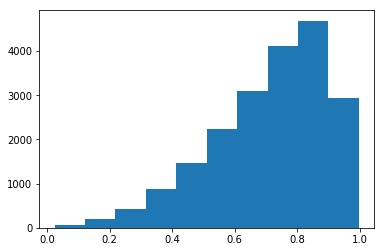

In [127]:
plt.hist(np.hstack((mouse_acc_test, mouse_acc_train)))

(array([  16.,   27.,   88.,  160.,  284.,  413.,  482.,  582.,  594.,  361.]),
 array([ 0.00856468,  0.10716404,  0.2057634 ,  0.30436276,  0.40296212,
         0.50156148,  0.60016084,  0.6987602 ,  0.79735956,  0.89595892,
         0.99455827]),
 <a list of 10 Patch objects>)

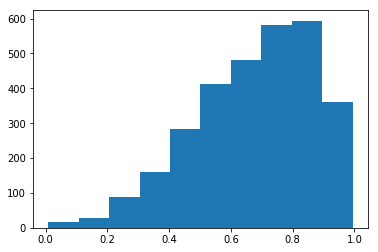

In [128]:
plt.hist(acc_test)

Text(31.9,0.5,'Frequency')

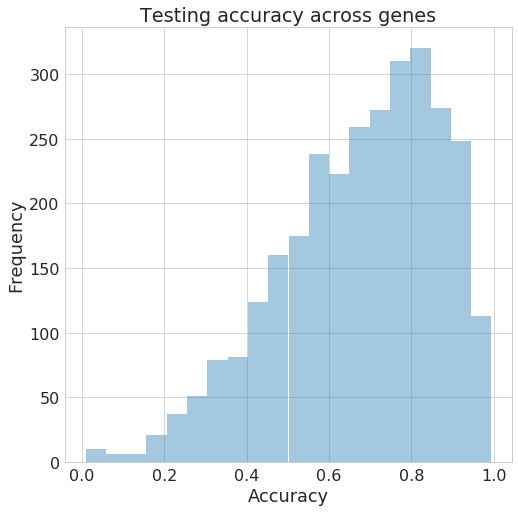

In [154]:
fig, ax = plt.subplots(figsize=(8,8))
sns.distplot(acc_test, bins=20, 
             kde=False, rug=False, ax=ax)
ax.set_title('Testing accuracy across genes')#.format(len(acc_test)))
plt.savefig('testing_accuracy_human.pdf', dpi=1000)
ax.set_xlabel('Accuracy')
ax.set_ylabel('Frequency')

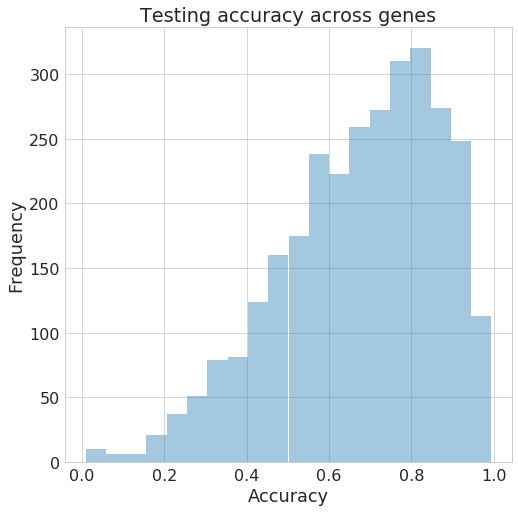

In [155]:
fig, ax = plt.subplots(figsize=(8,8))
sns.distplot(acc_test, bins=20, 
             kde=False, rug=False, ax=ax)
ax.set_title('Testing accuracy across genes')#.format(len(acc_test)))
ax.set_xlabel('Accuracy')
ax.set_ylabel('Frequency')
plt.savefig('testing_accuracy_human.pdf', dpi=1000)

In [135]:
np.mean(mouse_non_orthologous_genes_accuracy_test+mouse_non_orthologous_genes_accuracy_train)

0.70490121266224282

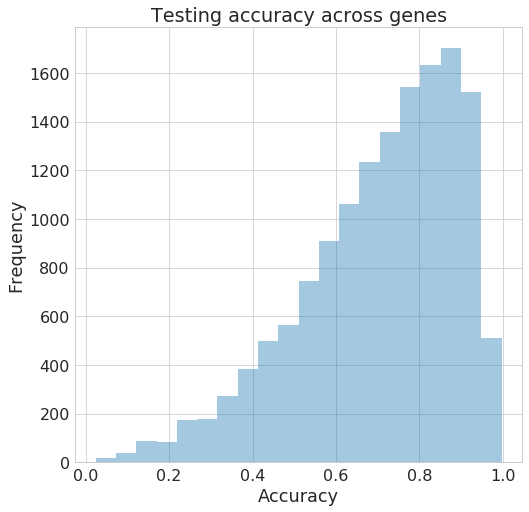

In [156]:
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=2)

#sns.distplot(mouse_non_orthologous_genes_accuracy_test+mouse_non_orthologous_genes_accuracy_train, bins=20, 
#             kde=False, rug=False)
#plt.hist(mouse_non_orthologous_genes_accuracy_test+mouse_non_orthologous_genes_accuracy_train)
fig, ax = plt.subplots(figsize=(8,8))
sns.distplot(mouse_non_orthologous_genes_accuracy_test+mouse_non_orthologous_genes_accuracy_train, bins=20, 
             kde=False, rug=False, ax=ax)
ax.set_title('Testing accuracy across genes')#.format(len(acc_test)))
ax.set_xlabel('Accuracy')
ax.set_ylabel('Frequency')
plt.savefig('testing_accuracy_mouse.pdf', dpi=1000)


In [136]:
np.mean(acc_testststst)

0.67583319226277994

In [164]:
len(mouse_gene_seq['ENSMUSG00000094200']['CDS'])

930

In [158]:
X_orig, Y_orig = one_hot_encoding(mouse_gene_seq['ENSMUSG00000094200'])

ENSMUSG00000094200_acc_test_orig = model.predict_classes(np.array([X_orig]), batch_size=1)
ENSMUSG00000094200_acc_orig = model.evaluate(np.array([X_orig]),np.array([Y_orig]), batch_size=1)

1/1 [==============================] - 0s


In [162]:
s= ''
for x in ENSMUSG00000094200_acc_test_orig[0][0:45]:
    s+=str(x)
    

In [165]:
s= ''
for x in ENSMUSG00000094200_acc_test_orig[0][45:930+45]:
    s+=str(x)
    

In [166]:
s

'111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111'

In [191]:
celegans_gene_cds = '../data/C_elegans_WBcel235/input/genes_cds.json'
celegans_gene_lengths = '../data/C_elegans_WBcel235/input/genes_lengths.json'



celegans_genes_dict, celegans_gene_seq = load_data(celegans_gene_cds, celegans_gene_lengths, 
                                             genes_to_keep=10868)

celegans_training_genes, celegans_test_genes = split_train_test_genes(celegans_genes_dict, train_proportion=0.7)

celegans_X_train = []
celegans_Y_train = []

celegans_X_test = []
celegans_Y_test = []

celegans_training_genes_filtered = []
celegans_test_genes_filtered  = []

for gene in celegans_training_genes:
    if 'N' in ('').join(celegans_gene_seq[gene].values()):
        continue
    X, Y = one_hot_encoding(celegans_gene_seq[gene])
    celegans_X_train.append(X)
    celegans_Y_train.append(Y)
    celegans_training_genes_filtered.append(gene)


for gene in celegans_test_genes:
    if 'N' in ('').join(celegans_gene_seq[gene].values()):
        continue
    X, Y = one_hot_encoding(celegans_gene_seq[gene])
    celegans_X_test.append(X)
    celegans_Y_test.append(Y)
    celegans_test_genes_filtered.append(gene)

In [193]:
celegans_acc_test = []
for  x_test, y_test in zip(celegans_X_test, celegans_Y_test):
    #acc_test = model.predict_classes(np.array([x_test]), batch_size=1)
    #break
    celegans_acc = model.evaluate(np.array([x_test]),np.array([y_test]), batch_size=1, verbose=0)
    celegans_acc_test.append(celegans_acc[1])
celegans_acc_test = np.array(celegans_acc_test)

In [194]:
celegans_acc_train = []
for  x_train, y_train in zip(celegans_X_train, celegans_Y_train):
    #acc_train = model.predict_classes(np.array([x_train]), batch_size=1)
    #break
    celegans_acc = model.evaluate(np.array([x_train]),np.array([y_train]), batch_size=1, verbose=0)
    celegans_acc_train.append(celegans_acc[1])
celegans_acc_train = np.array(celegans_acc_train)

In [195]:
np.argmax(celegans_acc_test)

772

In [196]:
celegans_acc_test[772]

0.98795181512832642

In [197]:
celegans_test_genes[772]

'WBGene00014090'

In [198]:
celegans_gene_seq['WBGene00014090']

{'CDS': 'ATGTACACTCGTCTCTCTATTCTTGTTGTCGTTTTTCTTGCAATTGGAACTGTCGACTCAAAGCACAAACATCATCAGAAAGGAAATGAGCCAGATTTCGTGAAAAATCTCACAAATTCTCAGAGAAGCTCGTTCTTTGGAATCGTCAAGAATCCAGGAATTTCATTTCAACAGAAGGACGATAAACTTGTGAAATGGGCAGAGGATAATAACCTTTCGGAGCAATACGCCGAGTTCTCAAAGAACATGACCATTCACAAGGAAGAAGTGAGCAAGAATATCAGTGGAGTCATCGATCGTCTTGCGGCTGCCAAAGTTGAAGTTGACAAGGTCAATGCTGATTTGAGTTTGACGAAGATTCAGAGAGACGAGAAAATCGATGAGCTCAAGAAGACCTACCCACAAGAAATCCCGACTCTCTTCTATATCGGTGGTCTTTTCGAGCATCCACGTAGAAATGAGACAAAAGGATCGGAAGGAAAGGGTGGAAGAAGAAAGCATCAA',
 'UTR3': 'TTCTAACATGTGCAAATAAATATTTGCTTTGCCTTTAACAAAAATTAATCGTATTA',
 'UTR5': 'AGACTTTTTTTTTGTCTTAAA'}

(array([   80.,   161.,   297.,   448.,   559.,   714.,   906.,  1035.,
         1705.,  1702.]),
 array([ 0.02415459,  0.12083222,  0.21750985,  0.31418749,  0.41086512,
         0.50754275,  0.60422038,  0.70089802,  0.79757565,  0.89425328,
         0.99093091]),
 <a list of 10 Patch objects>)

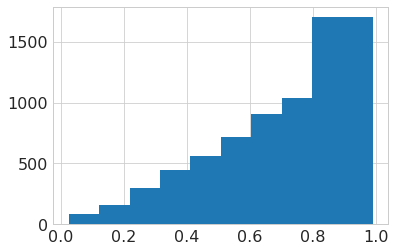

In [199]:
plt.hist(celegans_acc_train)

(array([  32.,   77.,  131.,  194.,  259.,  286.,  364.,  477.,  700.,  749.]),
 array([ 0.02293814,  0.11943951,  0.21594088,  0.31244224,  0.40894361,
         0.50544498,  0.60194635,  0.69844771,  0.79494908,  0.89145045,
         0.98795182]),
 <a list of 10 Patch objects>)

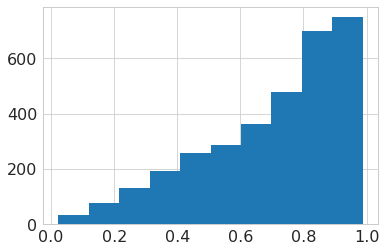

In [200]:
plt.hist(celegans_acc_test)

In [201]:
np.mean(celegans_acc_test)

0.69979436619793578

In [202]:
np.mean(celegans_acc_train)

0.70225983881663989

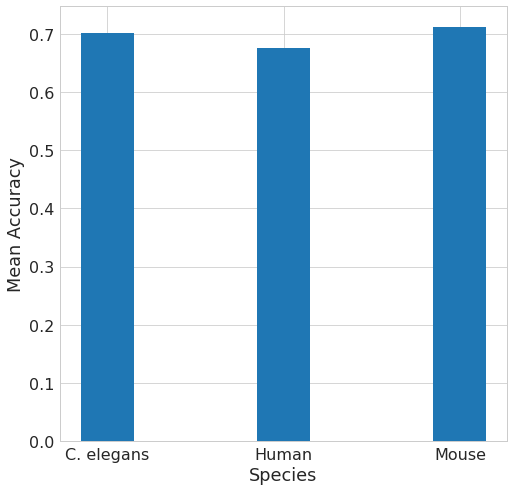

In [219]:
fix, ax = plt.subplots(figsize=(8,8))
ax.bar(['Human', 'Mouse','C. elegans'], [human_mean_acc_train,mouse_mean_acc,celegans_mean_acc], width=0.3)
ax.set_ylabel('Mean Accuracy')
ax.set_xlabel('Species')
plt.savefig('accuracy_species.pdf', dpi=1000)

In [204]:
mouse_mean_acc = np.mean(np.concatenate((mouse_acc_test, mouse_acc_train)))

In [205]:
celegans_mean_acc = np.mean(np.concatenate((celegans_acc_test, celegans_acc_train)))

In [206]:
human_mean_acc_train = np.mean(acc_train)

In [207]:
human_mean_acc_test = np.mean(acc_test)

In [208]:
human_mean_acc_test

1.4068501920614596

In [209]:
acc_test

array([[0, 0, 0, ..., 2, 2, 2]])

In [211]:
human_mean_acc_train

0.67596090823168098

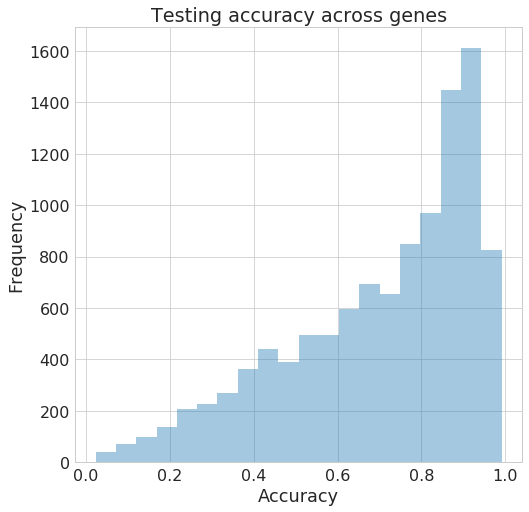

In [214]:
fig, ax = plt.subplots(figsize=(8,8))
sns.distplot(np.concatenate((celegans_acc_test, celegans_acc_train)), bins=20, 
             kde=False, rug=False, ax=ax)
ax.set_title('Testing accuracy across genes')#.format(len(acc_test)))
ax.set_xlabel('Accuracy')
ax.set_ylabel('Frequency')
plt.savefig('testing_accuracy_c_elegans.pdf', dpi=1000)

In [220]:
mouse_mean_acc

0.7113593608427663

In [221]:
celegans_mean_acc

0.70151879155748731